In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU no encontrada')
print('Encontrada GPU: {}'.format(device_name))

Encontrada GPU: /device:GPU:0


In [ ]:
# # confirm TensorFlow sees the GPU
# from tensorflow.python.client import device_lib
# assert 'GPU' in str(device_lib.list_local_devices())

In [ ]:
import os
import keras
import numpy as np
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
# from keras.layers import Input
from keras.optimizers import Adam

In [ ]:
# leer los dataset completos de cada tipo de x-ray

# covid_data_dir = os.path.join(os.path.abspath(os.getcwd()), 'drive/MyDrive/dataset-bueno/covid') 
# normal_data_dir = os.path.join(os.path.abspath(os.getcwd()), 'drive/MyDrive/dataset-bueno/nomal')
# virus_data_dir = os.path.join(os.path.abspath(os.getcwd()), 'drive/MyDrive/dataset-bueno/virus')
# bacteria_data_dir = os.path.join(os.path.abspath(os.getcwd()), 'drive/MyDrive/dataset-bueno/bacteria')

In [ ]:
# training_data_dir = os.path.join(os.path.abspath(os.getcwd()), 'drive/MyDrive/dataset/train') 
# testing_data_dir = os.path.join(os.path.abspath(os.getcwd()), 'drive/MyDrive/dataset/test')

# training_data_dir = os.path.join(os.path.abspath(os.getcwd()), 'drive/MyDrive/dataset-bueno/train') 
# testing_data_dir = os.path.join(os.path.abspath(os.getcwd()), 'drive/MyDrive/dataset-bueno/test')

folder = 'fold_1'

training_data_dir = os.path.join(os.path.abspath(os.getcwd()), 'drive/MyDrive/dataset-bueno/covid_vs_virus/'+folder+'/train') 
testing_data_dir = os.path.join(os.path.abspath(os.getcwd()), 'drive/MyDrive/dataset-bueno/covid_vs_virus/'+folder+'/test')

# Hyperparametros
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 30
BATCH_SIZE = 3
TEST_SIZE = 2
# learning_rate = 0.00001
input_size = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"

In [ ]:
def load_datasets(training_data_dir, testing_data_dir, IMAGE_SIZE, BATCH_SIZE): 
  IMAGE_WIDTH, IMAGE_HEIGHT= IMAGE_SIZE, IMAGE_SIZE
  TEST_SIZE = 2
  input_shape= (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
  # Creamos los objetos para hacer el Data Augmentation
  # rescale=1/.255 -> pasar los valores de los pixeles [0,255] a [0,1]
  # shear_range=0.1 -> angulo de deformacion en sentido contrario a las manecillas del reloj (distorsion de perspectiva y lente)
  # zoom_range=0.1 -> Range for random zoom [1-zoom_range, 1+zoom_range]
  # horizontal_flip=True -> Voltear horizontalmente las imagenes de manera aleatoria

  training_data_generator = ImageDataGenerator(rescale=1./255, shear_range=0.1, zoom_range=0.1, horizontal_flip=True)
  validation_data_generator = ImageDataGenerator(rescale=1./255)
  testing_data_generator = ImageDataGenerator(rescale=1/.255)

  training_generator = training_data_generator.flow_from_directory(
      training_data_dir,
      target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
      batch_size=BATCH_SIZE,
      class_mode="categorical")
  
  validation_generator = validation_data_generator.flow_from_directory(
      testing_data_dir,
      target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
      batch_size=BATCH_SIZE,
      class_mode="categorical",
      shuffle=False)
  
  testing_generator = testing_data_generator.flow_from_directory(
    testing_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False)
  
  return training_generator, validation_generator, testing_generator

In [ ]:
training_generator, validation_generator, testing_generator = load_datasets(training_data_dir, testing_data_dir, IMAGE_SIZE, BATCH_SIZE)
# training_generator, validation_generator = load_datasets(training_data_dir, testing_data_dir, IMAGE_SIZE, BATCH_SIZE)

Found 1467 images belonging to 2 classes.
Found 367 images belonging to 2 classes.
Found 367 images belonging to 2 classes.


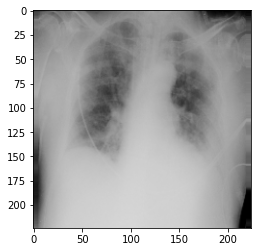

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(training_generator[0][0][0])

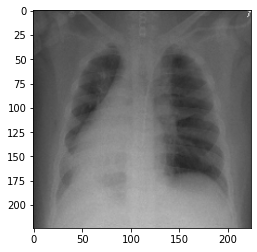

In [ ]:
plt.imshow(training_generator[0][0][1])
plt.show()

In [ ]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, AveragePooling2D, Flatten, Dense, Dropout
from keras.models import Model

In [ ]:
def bloque_convolucional(X, f, filters, stage, block, s=2):
  """
    Argumentos:
        X: entrada, tensor de tamaño shape = (m, Height_prev, Width_prev, Dept_prev).
        f: tamaño del filtro o kernel de convolucion, entero.
        filters: numero de filtros en en las capas de convolucion, tupla (deben ser 3) de enteros.
        stage: numero de etapa (2 a 5), usado para nombrar las capas y que summary() pueda reportarlas.
        block: una letra para identificar cada bloque dentro de cada etapa ('a','b','c', etc.), tipo 'str'.    
        s: el tamaño del paso para aplicar los filtros que lo requieran
    Returns:
        X: salida del bloque, tensor de tamaño shape=(Height, Width, Depth). """
    
  # Nombre base para identificar cada Layer
  CONV_name = 'RES' + str(stage) + block + '-br-' # "br"="branch" main branch:1, shortcut branch: 2.
  BranchNorm_name = 'BN' + str(stage) + block + '-br-'

  f1, f2, f3 = filters # Cantidad de filtros en cada capa (la 3a capa del main y la capa del atajo usan f3 filtros)  
  X_original = X # guardamos la entrada para procesarla en la conexion de atajo.

  #--- Main Path (branch 1) ---

  # 1er componente de la rama principal (etiqueta '1a'):
  X = Conv2D(filters=f1, kernel_size=(1,1), strides=(s,s), padding='valid', name=CONV_name+'1a')(X)
  X = BatchNormalization(axis=3, name=BranchNorm_name+'1a')(X)
  X = Activation('relu')(X)

  # 2do componente de la rama principal (etiqueta '1b')
  X = Conv2D(filters=f2, kernel_size=(f,f), strides=(1,1), padding="same", name=CONV_name+'1b')(X)
  X = BatchNormalization(axis=3, name=BranchNorm_name+'1b')(X)
  X = Activation('relu')(X)

  # 3er componente de la rama principal (etiqueta '1c')
  X = Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding="valid", name=CONV_name+'1c')(X)
  X = BatchNormalization(axis=3, name=BranchNorm_name+'1c')(X)

   #--- Shortcut Path (branch 2) ---
   # Unico componente de la rama de atajo (etiqueta '2'):
  X_shortcut = Conv2D(filters=f3, kernel_size=(1,1), strides=(s,s), padding='valid', name=CONV_name+'2')(X_original)
  X_shortcut = BatchNormalization(axis=3, name=BranchNorm_name+'2')(X_shortcut)

  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X



In [ ]:
def bloque_identidad(X, f, filters, stage, block):
  """
  Argumentos:
      X: entrada, tensor de tamaño shape = (m, Height_prev, Width_prev, Dept_prev).
      f: tamaño del filtro o kernel de convolucion, entero.
      filters: numero de filtros en en las capas de convolucion, tupla (deben ser 3) de enteros.
      stage: numero de etapa (2 a 5), usado para nombrar las capas y que summary() pueda reportarlas.
      block: una letra para identificar cada bloque dentro de cada etapa ('a','b','c', etc.), tipo 'str'.    
  Returns:
      X: salida del bloque, tensor de tamaño shape=(Height, Width, Depth). """
  
  # nombre base para nombrar cada capa
  CONV_name = 'RES' + str(stage) + block + '-br-'  # "br"="branch" main branch:1, shortcut branch: 2.
  BranchNorm_name = 'BN' + str(stage) + block + '-br-'

  f1, f2, f3 = filters # Cantidad de filtros en cada capa del bloque (son 3 capas)        
  X_original = X # guardamos la entrada para sumarla al final (conexion de atajo)

  #--- Main Path (branch 1) ---

  # 1er componente de la rama principal (etiqueta '1a')
  # (3 lineas de codigo)
  X = Conv2D(f1, (1,1), strides=(1,1), padding='valid', name=CONV_name+'1a')(X)
  X = BatchNormalization(axis = 3, name = BranchNorm_name + '1a')(X)
  X = Activation('relu')(X)
      
  # 2do componente de la rama principal (etiqueta '1b')
  # (3 lineas de codigo)
  X = Conv2D(f2, (f,f), strides=(1,1), padding='same', name=CONV_name+'1b')(X)
  X = BatchNormalization(axis = 3, name = BranchNorm_name + '1b')(X)
  X = Activation('relu')(X)
  
  # 3er componente de la rama principal (etiqueta '1c')
  # (2 lineas de codigo)
  X = Conv2D(f3, (1,1), strides=(1,1), padding='valid', name=CONV_name+'1c')(X)
  X = BatchNormalization(axis = 3, name = BranchNorm_name + '1c')(X)
      
  #--- Shortcut Path (branch 2) ---
  # El bloque indentity no requiere operaciones en la rama 2
    
  X = Add()([X, X_original]) # <-- completar. Sumar X y X_original
  X = Activation('relu')(X) # <-- completar. Aplicar la funcion de activacion.  
    
  return X



In [ ]:
# Crear el modelo

def RestNet50(input_shape, classes):
  """
    Argumentos:
        input_shape: tupla, tamaño de los datos (imagenes) de entrada (H, W, D).
        classes: numero de clases en el problema, entero.
    Returns:
        model: una instancia del modelo implementado en Keras."""
  X_input = Input(input_shape) # Define la entrada como un tensor con la forma indicada
  
  # Capa 1
  X = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), name='CONV1')(X_input)
  X = BatchNormalization(axis=3, name='BN-CONV1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D(pool_size=(3,3), strides=(2,2))(X)

  # Capa 2
  X = bloque_convolucional(X, f=3, filters=[64,64,256], stage=2, block='a', s=1)
  X = bloque_identidad(X, f=3, filters=[64,64,256], stage=2, block='b')
  X = bloque_identidad(X, f=3, filters=[64,64,256], stage=2, block='c')

  # Capa 3
  X = bloque_convolucional(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
  X = bloque_identidad(X, 3, [128, 128, 512], stage=3, block='b')
  X = bloque_identidad(X, 3, [128, 128, 512], stage=3, block='c')
  X = bloque_identidad(X, 3, [128, 128, 512], stage=3, block='d')

  # Capa 4
  X = bloque_convolucional(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
  X = bloque_identidad(X, 3, [256, 256, 1024], stage=4, block='b')
  X = bloque_identidad(X, 3, [256, 256, 1024], stage=4, block='c')
  X = bloque_identidad(X, 3, [256, 256, 1024], stage=4, block='d')
  X = bloque_identidad(X, 3, [256, 256, 1024], stage=4, block='e')
  X = bloque_identidad(X, 3, [256, 256, 1024], stage=4, block='f')

  # Capa 5
  X = bloque_convolucional(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
  X = bloque_identidad(X, 3, [512, 512, 2048], stage=5, block='b')
  X = bloque_identidad(X, 3, [512, 512, 2048], stage=5, block='c')

  X = AveragePooling2D(pool_size=(2,2), strides=None, name = "avg_pool")(X) 

  # Aplanado de los datos y capa Fully Connected FC (dense)
  X = Flatten()(X)
  X = Dropout(0.5)(X)
  X = Dense(classes, activation='softmax', name='FC'+str(classes))(X)

  # Una vez definido, crear el modelo, objeto de la clase "Model":
  model = Model(inputs = X_input, outputs = X, name='ResNet_50_layers')

  return model

In [ ]:
# training_generator.filenames    # 'covid/covid39.jpg', 'normal/normal14.jpeg',
# training_generator.classes      # [0,0,0,0,.....,1,1,1,1]
# training_generator.target_size  # (224, 224) 
# training_generator.color_mode    # rgb
# training_generator.class_mode   # Categorical
# training_generator.batch_size   # 2
# training_generator.data_format  # channels_last

In [ ]:
# Forma de training_generator -> (2,224,224,3)
# 2 -> covid y normal
# 224 x 224 tamaño de la foto
# 3 -> # canales RGB  

size_images = (training_generator.target_size[0],training_generator.target_size[1],3)


# Crear el modelo
# model = RestNet50(input_shape=size_images, classes=training_generator.batch_size)
model = RestNet50(input_shape=size_images, classes=len(np.unique(training_generator.classes)))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-5,beta_1=0.9, beta_2=0.999, name='Adam')
# Compilar el modelo (necesario en Keras)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
 #! pip install livelossplot

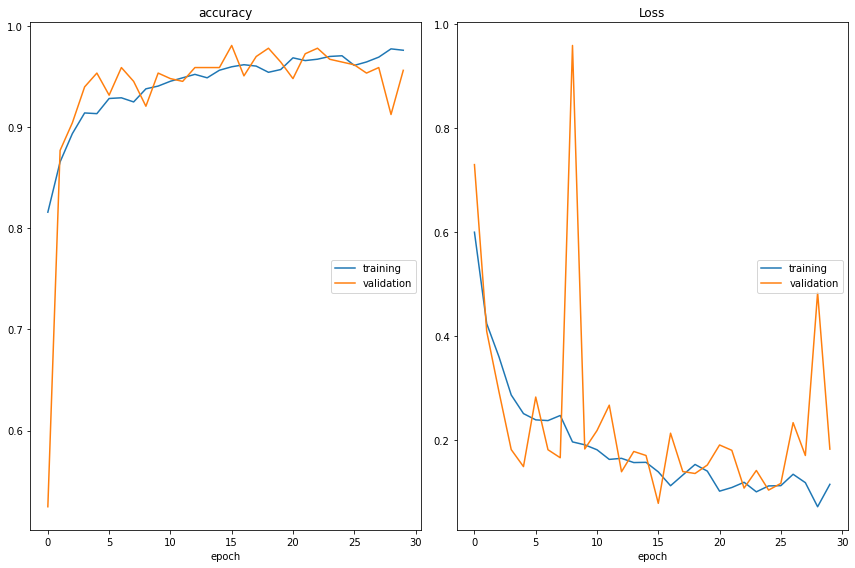

accuracy
	training         	 (min:    0.816, max:    0.978, cur:    0.976)
	validation       	 (min:    0.525, max:    0.981, cur:    0.956)
Loss
	training         	 (min:    0.073, max:    0.600, cur:    0.116)
	validation       	 (min:    0.079, max:    0.959, cur:    0.183)

Tiempo de ejecucion:  2555.5576632330003 seconds


In [ ]:
# !pip install livelossplot
import time
from keras.callbacks import CSVLogger
from livelossplot import PlotLossesKeras
# Entrenar el modelo
# model.fit(train_X, train_Y, epochs = 1, batch_size = 32)

start_time = time.perf_counter()

H = model.fit_generator(training_generator,
                    steps_per_epoch = len(training_generator.filenames)//BATCH_SIZE,  # len(training_generator.filenames) = 80
                    epochs = EPOCHS,
                    validation_data = validation_generator,
                    validation_steps = len(validation_generator.filenames)//BATCH_SIZE, # len(training_generator.filenames) = 20
                    callbacks = [PlotLossesKeras(), CSVLogger(TRAINING_LOGS_FILE, append=False, separator=";")],
                    verbose = 1)

print("\nTiempo de ejecucion: ",time.perf_counter() - start_time, "seconds")

In [ ]:
# H.history
# {'accuracy':[,,,,], 
#  'loss':[,,,,], 
#  'val_accuracy':[,,,,], 
#  'val_loss':[,,,,]}

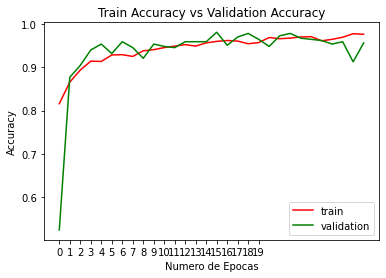

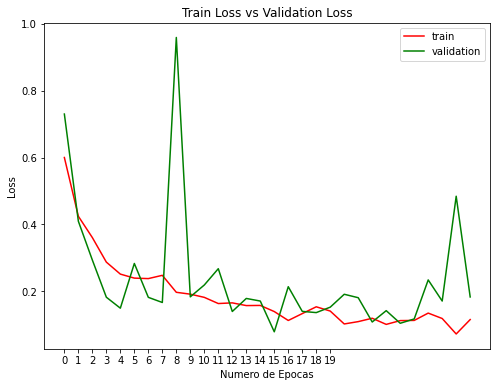

In [ ]:
# Crear Graficas 1er forma
plt.figure(0)
plt.plot(model.history.history['accuracy'],'r')
plt.plot(model.history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 20, 1.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Numero de Epocas")
plt.ylabel("Accuracy")
plt.title("Train Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(model.history.history['loss'],'r')
plt.plot(model.history.history['val_loss'],'g')
plt.xticks(np.arange(0, 20, 1.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Numero de Epocas")
plt.ylabel("Loss")
plt.title("Train Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

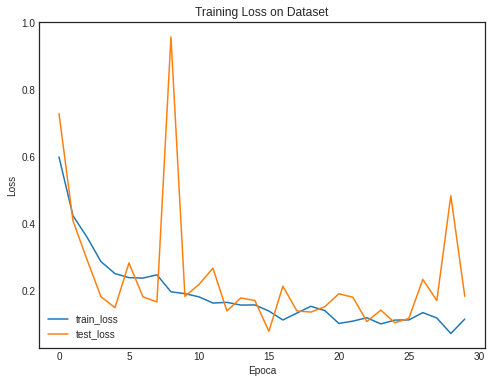

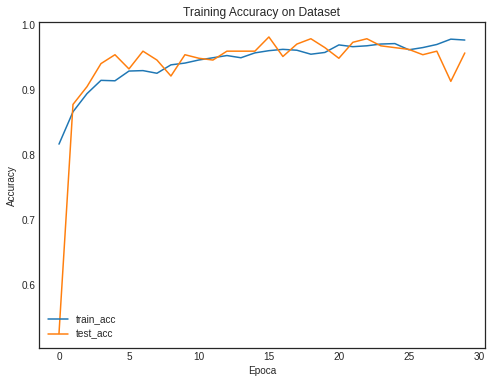

In [ ]:
# Graficar Loss y Accuracy 2da forma
plt.style.use("seaborn-white")
plt.figure(0)
plt.plot(np.arange(0, EPOCHS), model.history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), model.history.history["val_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("Loss.png")

plt.style.use("seaborn-white")
plt.figure(1)
plt.plot(np.arange(0, EPOCHS), model.history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), model.history.history["val_accuracy"], label="test_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoca")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("Accuracy.png")

In [ ]:
# Evaluar el entrenamiento con el dataset de validacion 
evaluacion = model.evaluate_generator(validation_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False)
print(evaluacion)
# print ("Perdida = " + str(preds[0]))
# print ("Accuracy de evaluacion = " + str(preds[1]))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.18272936344146729, 0.9564032554626465]


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


123/123 [==============================] - 12s 71ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
confussion matriz


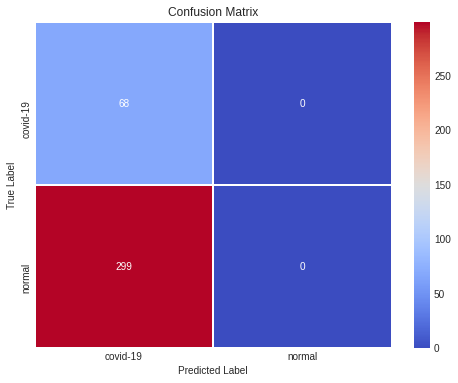

[[ 68   0]
 [299   0]]
Classification Report
              precision    recall  f1-score   support

    covid-19       0.19      1.00      0.31        68
      normal       0.00      0.00      0.00       299

    accuracy                           0.19       367
   macro avg       0.09      0.50      0.16       367
weighted avg       0.03      0.19      0.06       367



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def show_confusion_matrix(data, predictions, LABELS):
  matrix = confusion_matrix(data, predictions)
  plt.figure(figsize=(8, 6))

  sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
  plt.title("Confusion Matrix")
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

LABELS = ["covid-19","normal"] # indicamos manualmente cuales son las etiquetas que tiene nuestro problema

#Evaluar el dataset de prueba
pred = model.predict_generator(testing_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1) 
# print(pred)
predicted = np.argmax(pred, axis=1)
print(predicted)
print('confussion matriz')
show_confusion_matrix(testing_generator.classes, predicted, LABELS)
print(confusion_matrix(testing_generator.classes, predicted))

print('Classification Report')
target_names = ["covid-19","normal"]
print(classification_report(testing_generator.classes, predicted, target_names=target_names))

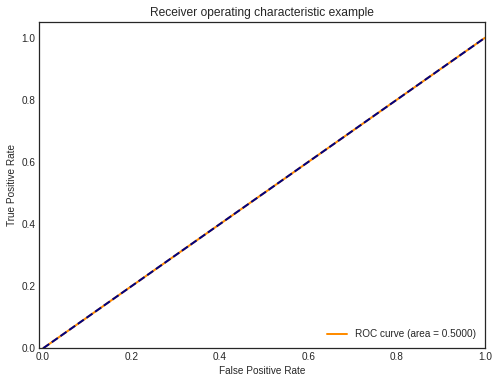

In [ ]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
   fpr[i], tpr[i], _ = roc_curve(testing_generator.classes, predicted)
   roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()

lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
       lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# print(predicted)

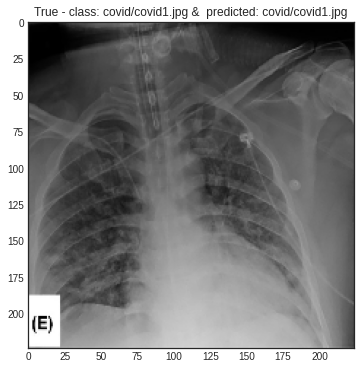

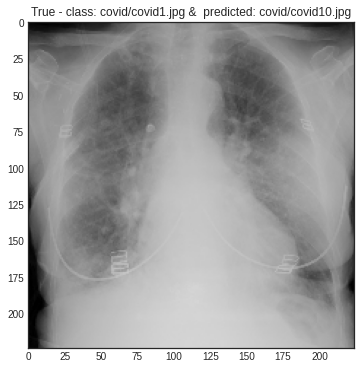

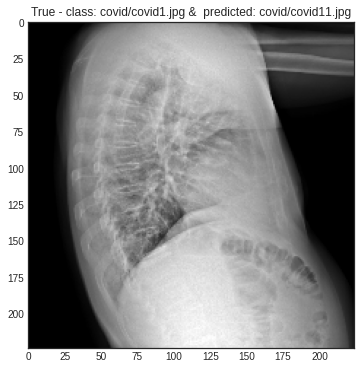

In [ ]:
def predict_one(model, validation_generator):
  image_bacth, classes_batch = next(validation_generator)
  predicted_batch = model.predict(image_bacth)

  for k in range(0, image_bacth.shape[0]):
    image = image_bacth[k]
    pred = predicted_batch[k]
    the_pred = np.argmax(pred)
    predicted = validation_generator.filenames[k]
    val_pred = max(pred)
    the_class = np.argmax(classes_batch[k])
    value = validation_generator.filenames[np.argmax(classes_batch[k])]
    plt.figure(k)
    isTrue = (the_pred == the_class)
    plt.title(str(isTrue)+' - class: '+value +" & "+' predicted: '+predicted)
    plt.imshow(image)
  
predict_one(model, validation_generator)